# Heart Disease Prediction

Heart diseases are increasing at a rapid rate and it's very important, along with others problems medicine is trying to tackle, to have a better prediction of such diseases beforehand. In this notebook we'll be focusing on which patients are most likely to have a heart disease based on several given medical attributes from Kaggle's [*Heart Disease UCI*](https://www.kaggle.com/ronitf/heart-disease-uci) dataset.

We'll first load the dataset, then do an Exploratory Data Analysis (EDA) to find more about the data and then some data preprocessing for being ready to start using different machine learning algorithms. We'll try out different algorithms such as Logistic Regression, KNN, Decision Trees, Random Forests and XGBoost and SVM Classifier. Then we'll take the most promising classifiers and try an ensemble model for trying to achieve even better results.


## 1. Loading the dataset

We can directly download the .csv file from the link above but we'll be using Kaggle's API instead. For this, you first have to install Kaggle's package using `pip install Kaggle`. For further information this you can check this [video](https://www.youtube.com/watch?v=DgGFhQmfxHo) that explains it in a simple way.

In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [2]:
api = KaggleApi()
api.authenticate()

In [3]:
api.dataset_download_file('ronitf/heart-disease-uci',
                          file_name = 'heart.csv')

False

You should get that 'True' that means that the dataset downloaded correctly to the path in which your notebook is. If you want to move it into another folder you can use the `shutil` or `os` libraries for that.

Now let's import some more libraries that we'll use and load the dataset into a Pandas DataFrame.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('seaborn')

In [5]:
# Reading the .csv
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Regarding this features, here's a better description on what they resemble:
- `age`: age (in years)
- `sex`: 0 for female, 1 for male
- `cp`: Chest Pain type:
    - *Typical angina (0)*: chest pain related to decrease in blood supply to the heart.
    - *Atypical angina (1)*: chest pain not related to the heart.
    - *Non-anginal pain (2)*: some not-heart-related spasms.
    - *Asymptomatic (3)*: chest pain not showing signs of disease.
- `trestbps`: resting blood presure (in mmHg). Above 130-140 is typically a cause for concern.
- `chol`: serum cholestoral (in mg/dl). Above 200 is cause for concern.
- `fbs`: fasting blood sugar (1 if > 120mg/dl, 0 otherwise).
- `restecg`: resting electrocardiographic results:
    - *0*: nothing to note
    - *1*: ST-T wave abnormality (non-normal heart beat)
    - *2*: Possible or definite left ventricular hypertrophy
- `thalach`: maximum heart rate achieve
- `exang`: exercise induced angina (1 = yes, 0 = no)
- `oldpeak`: ST depression induced by excercise relative to rest (stress of heart during excercise)
- `slope`: the slope of the peak excercise ST segment
    - *Upsloping (0)*: better heart rate with excercise (uncommon)
    - *Flatsloping (1)*: minimal change (typical healthy heart)
    - *Downsloping (2)*: signs of unhealthy heart
- `ca`: number of major vessels colored by flourosopy (0-3). The more colored vessels, the better blood movement (less clots).
- `thal`> thalium stress result. The larger the worse blood movement (between 1 and 7).
- `target`: patient has a heart disease or not (1 = yes, 0 = no)

## 2. Exploratory Data Analysis (EDA)

First let's take a deeper look into the missing values and data types

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [7]:
pd.set_option('display.float', '{:.2f}'.format)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.00,54.37,9.08,29.00,47.50,55.00,61.00,77.00
sex,303.00,0.68,0.47,0.00,0.00,1.00,1.00,1.00
cp,303.00,0.97,1.03,0.00,0.00,1.00,2.00,3.00
trestbps,303.00,131.62,17.54,94.00,120.00,130.00,140.00,200.00
chol,303.00,246.26,51.83,126.00,211.00,240.00,274.50,564.00
fbs,303.00,0.15,0.36,0.00,0.00,0.00,0.00,1.00
restecg,303.00,0.53,0.53,0.00,0.00,1.00,1.00,2.00
thalach,303.00,149.65,22.91,71.00,133.50,153.00,166.00,202.00
exang,303.00,0.33,0.47,0.00,0.00,0.00,1.00,1.00
oldpeak,303.00,1.04,1.16,0.00,0.00,0.80,1.60,6.20


There are no missing values so no need of eliminating rows/filling the missing values with another statistical values. Also, these are all numerical values, so we don't have to use Encoders either.

Also, as the mean of `target` is 0.54, then 54% of the patients in the dataset has a heart disease and the remaining 46% has not.

In [8]:
# Values' count for the target column
target_values = pd.DataFrame(df,columns = ['target']).groupby(['target']).size()
target_values

target
0    138
1    165
dtype: int64

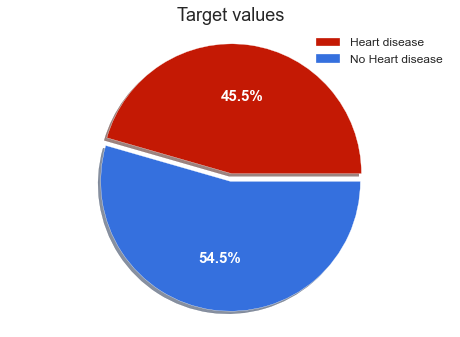

In [9]:
# Pie chart with targets' %
tgt_labels = 'Heart disease', 'No Heart disease'
tgt_colors = ['#c41904','#3570de']
tgt_explode = (.03, .03)

plt.pie(target_values, labels = tgt_labels, autopct='%1.1f%%',
       shadow = True, colors = tgt_colors, explode = tgt_explode,
       textprops={'color': 'w', 'fontsize': 15, 'weight':'bold',
                  'multialignment': 'center'})

plt.title('Target values', fontsize= 18)
plt.legend(fontsize = 12)
plt.axis('equal')

plt.show()

Now let's separate the categorical values from the continuos values. As there's not a precise division between what should be considered categorical and what not, we should take a treshold (i.e. in this notebook columns that have 8 or less unique values, will be considered as categorical and the remaining will be considered as continuous).

In [10]:
# Dividing our features into categorical and continuous
cat_cols = []
cont_cols = []

for col in df.columns:
    print(str(len(df[col].unique())).ljust(3), ' different values in feature ', col)
    if len(df[col].unique()) <= 8:
        cat_cols.append(col)
    else:
        cont_cols.append(col)

print()
print('\033[1m', 'Categorical features: ', '\033[0m', cat_cols, end = '\n\n')
print('\033[1m', 'Continuous features: ', '\033[0m', cont_cols)

41   different values in feature  age
2    different values in feature  sex
4    different values in feature  cp
49   different values in feature  trestbps
152  different values in feature  chol
2    different values in feature  fbs
3    different values in feature  restecg
91   different values in feature  thalach
2    different values in feature  exang
40   different values in feature  oldpeak
3    different values in feature  slope
5    different values in feature  ca
4    different values in feature  thal
2    different values in feature  target

 Categorical features:   ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']

 Continuous features:   ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


We have 8 categorical features (excluding the `target`) and 5 continuous features. let's first take a look into the continuous features and how their values vary.

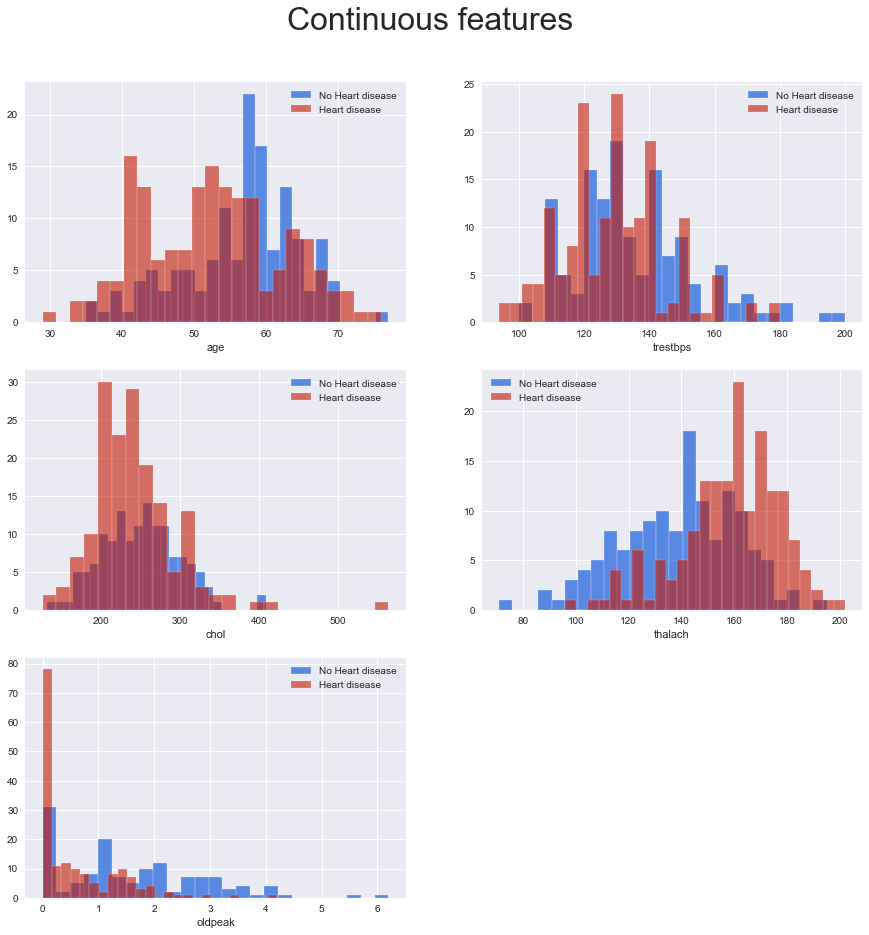

In [11]:
# Plotting continuous features
fig = plt.figure(figsize = (15, 15))
fig.suptitle('Continuous features', fontsize = 32, y = 0.95)

for i, col in enumerate(cont_cols, 1):
    plt.subplot(3, 2, i)
    
    df[df['target'] == 0][col].hist(bins = 25, color = '#3570de',
                                    label = 'No Heart disease', alpha = 0.8)
    df[df['target'] == 1][col].hist(bins = 25, color = '#c41904',
                                    label = 'Heart disease', alpha = 0.6)
    
    plt.xlabel(col)
    plt.legend()

Here we can see, for example, that the `age` of people having heart diseases occur mostly between the age of 40 and 70, while no heart diseases between 55 and 70.

Looking at the resting blood preasure (`trestbps`) we said that anything above 130-140 is typically cause for concern.

Having a `chol` above 200 is cause for concern.

Regarding the maximum heart rate achieved (`thalach`) we can see that people with heart diseases tend to achieve greater values than people without heart diseases.

And last, the `oldpeak` is the ST depression induced by exercise relative to rest looks at stress of heart during exercise. Unhealthy hearts will stress more.

Now let's take a look at the correlations of this features with a pairplot.

Text(0.5, 1.04, 'Continuous features Pairplot')

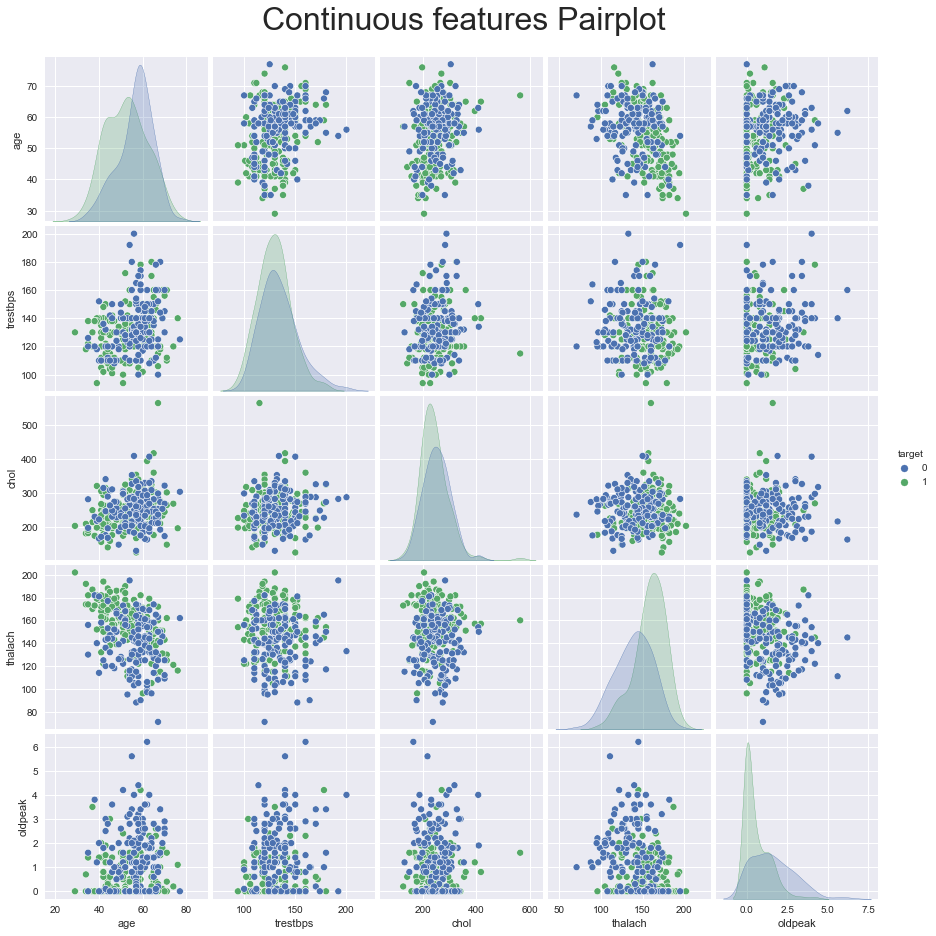

In [12]:
# Pairplot for continuous features
pairplot = sns.pairplot(df[cont_cols + ['target']], hue = 'target')
pairplot.fig.suptitle("Continuous features Pairplot", fontsize = 32, y = 1.04)

Let's also take a look into our categorical features, but let's first remove the `target` as it's not a feature but the value we want to predict.

In [13]:
cat_cols.remove('target')

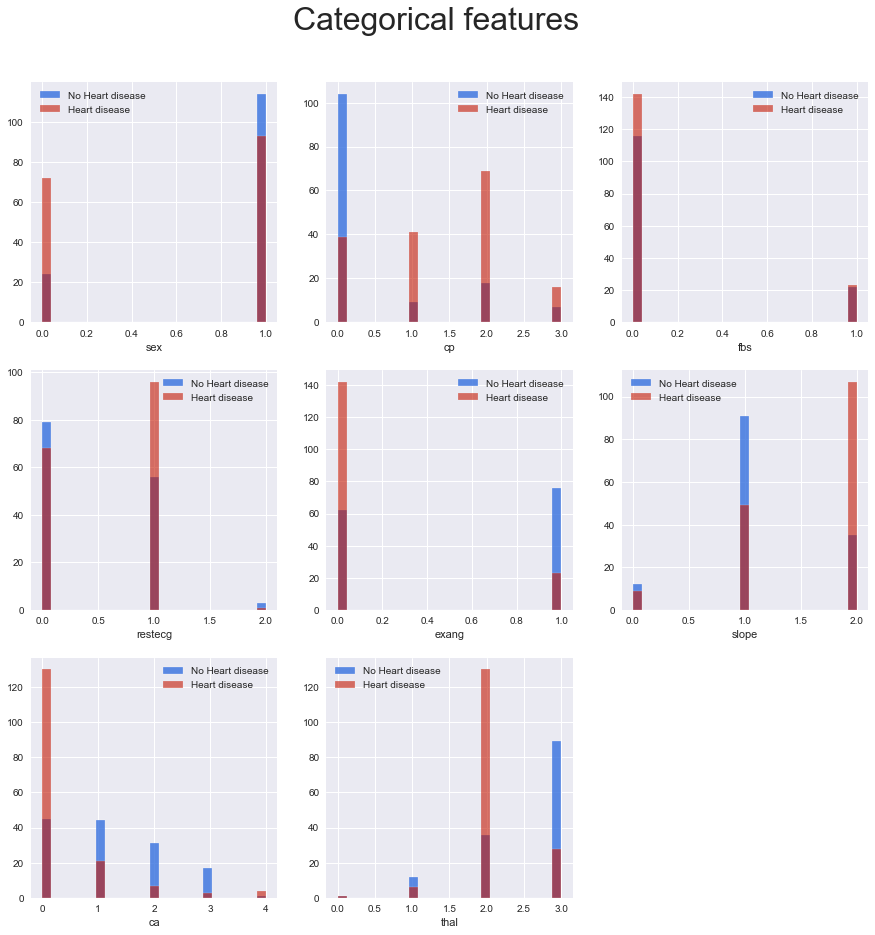

In [14]:
# Plotting continuous features
fig = plt.figure(figsize = (15, 15))
fig.suptitle('Categorical features', fontsize = 32, y = 0.95)

for i, col in enumerate(cat_cols, 1):
    plt.subplot(3, 3, i)
    
    df[df['target'] == 0][col].hist(bins = 25, color = '#3570de',
                                    label = 'No Heart disease', alpha = 0.8)
    df[df['target'] == 1][col].hist(bins = 25, color = '#c41904',
                                    label = 'Heart disease', alpha = 0.6)
    
    plt.xlabel(col)
    plt.legend()

For `sex` we can se that in our data, approx 75% of female (sex = 0) have heart diseases and around 45% of males too.

Medically speaking, the closer the chest pain type (`cp`) is to 0, the more likely the patient is to have a heart disease.

When the fasting blood sugar (`fbs`) is 1, it could be signalling diabetes (or related diseases).

The greater the `restecg` also notices signals of heart diseases.

Regarding the `slope`, slope = 2 are a sign of unhealthy hearts.

When the number of major vessels (`ca`) is closer to 0, this could be evidencing clots. If it's closer to 3, it shows better blood movement.

And `thal` could show normal results while closer to 1, and no propper blood movement when the patient is exercising while closer to 7.

And our last steps for the EDA will be plotting a Correlation Matrix between all features and detecting which features have a stronger correlation (either positive or negative) with our `target` value.

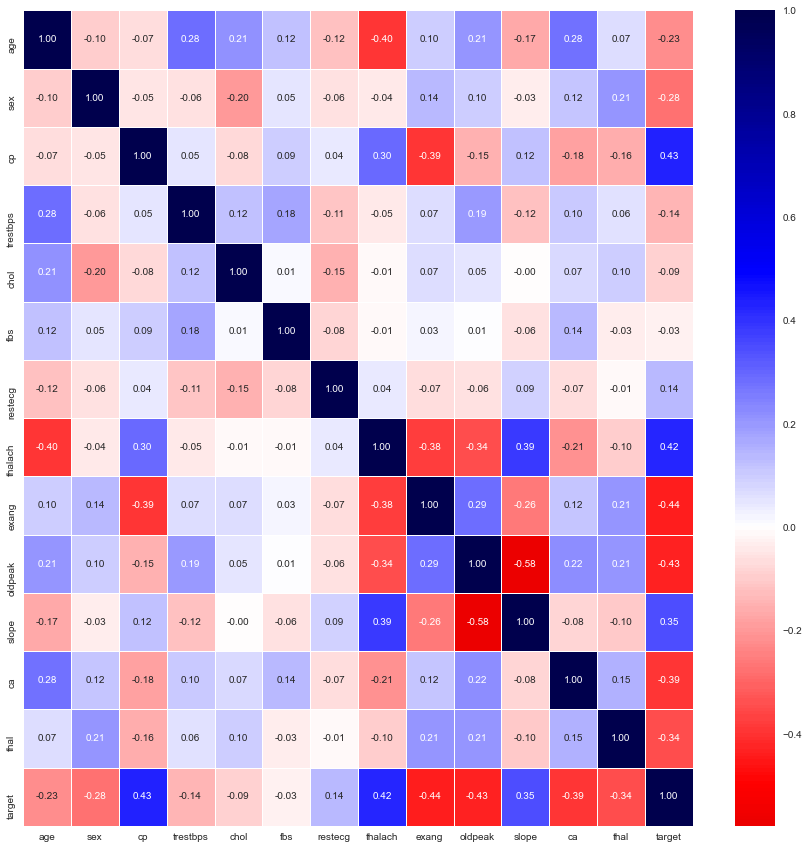

In [15]:
# Correaltion Matrix
corr_matrix = df.corr()

fig, ax = plt.subplots(figsize = (15, 15))
ax = sns.heatmap(corr_matrix, annot = True, fmt = '.2f',
                 cmap = 'seismic_r', center = 0, linewidths = 0.5)

For other heatmap palettes you can check out this [link](https://medium.com/@morganjonesartist/color-guide-to-seaborn-palettes-da849406d44f). Also, I usually prefer to focus on the correlations that matter (not the diagonal), so I usually look into the lower triangle of the matrix. You can check this by doing the following

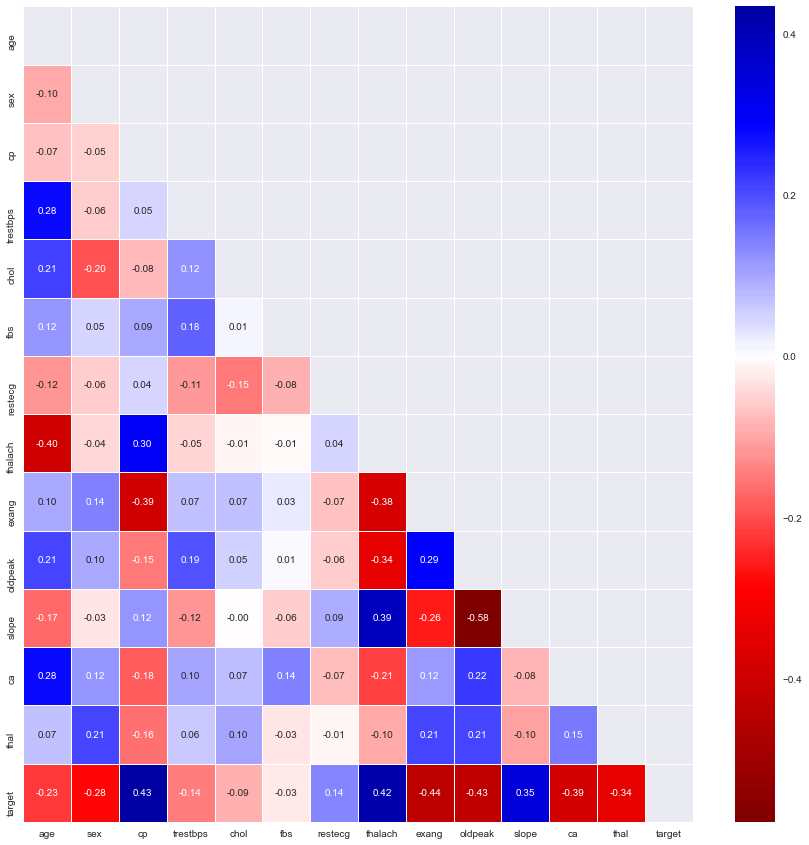

In [16]:
# Correaltion Matrix
corr_matrix = df.corr()
matrix = np.triu(corr_matrix)

fig, ax = plt.subplots(figsize = (15, 15))
ax = sns.heatmap(corr_matrix, mask = matrix, annot = True, fmt = '.2f',
                 cmap = 'seismic_r', center = 0, linewidths = 0.5)

Now let's see how each feature correlates with the `target` value

<AxesSubplot:title={'center':"Features' correlation with target"}>

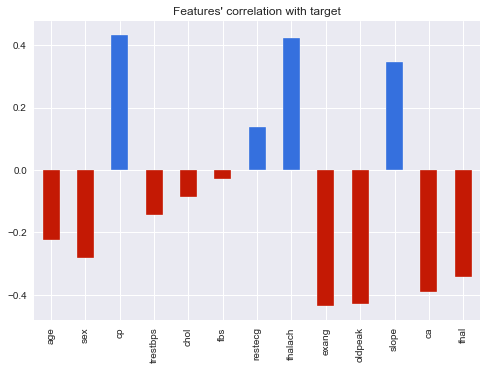

In [17]:
df.drop('target', axis = 1).corrwith(df.target).plot(kind = 'bar', grid = True, title = "Features' correlation with target", color=np.where(df.drop('target', axis = 1).corrwith(df.target) > 0, '#3570de', '#c41904'))

Here we can see that the features lower correlated with the target value are `fbs` and `chol`, whereas `trestbps` and `restecg` could be considered either low or significante (there's no precise treshold for this). All the other variables have significant correlation with the target.

## 3. Data Preprocessing

After we did this EDA, we can now proceed with the preprocessing thath should be needed for starting to try different ML algorithms. In particular, some of them would require `feature scalling` and we should convert some categorical variables into dummy variables.

In [18]:
# Categorical to dummies
df = pd.get_dummies(df, columns = cat_cols)
df.head()

,age,trestbps,chol,thalach,oldpeak,target,sex_0,sex_1,cp_0,cp_1,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
0,63,145,233,150,2.30,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1,37,130,250,187,3.50,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
2,41,130,204,172,1.40,1,1,0,0,1,...,1,1,0,0,0,0,0,0,1,0
3,56,120,236,178,0.80,1,0,1,0,1,...,1,1,0,0,0,0,0,0,1,0
4,57,120,354,163,0.60,1,1,0,1,0,...,1,1,0,0,0,0,0,0,1,0


In this notebook we'll be using sklearn's `Standard Scaler`

In [19]:
from sklearn.preprocessing import StandardScaler

# Scaling continuous values
std_scaled = df
ss = StandardScaler()
std_scaled[cont_cols] = ss.fit_transform(std_scaled[cont_cols])

df.head()

,age,trestbps,chol,thalach,oldpeak,target,sex_0,sex_1,cp_0,cp_1,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
0,0.95,0.76,-0.26,0.02,1.09,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1,-1.92,-0.09,0.07,1.63,2.12,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
2,-1.47,-0.09,-0.82,0.98,0.31,1,1,0,0,1,...,1,1,0,0,0,0,0,0,1,0
3,0.18,-0.66,-0.20,1.24,-0.21,1,0,1,0,1,...,1,1,0,0,0,0,0,0,1,0
4,0.29,-0.66,2.08,0.58,-0.38,1,1,0,1,0,...,1,1,0,0,0,0,0,0,1,0


Now, our continuous features should be scaled in thw way the data forms a Normal distribution centered in zero. We can look at this by plotting again this values as they were plot before, but without splitting the data into patients that have heart diseases and those who doesn't.

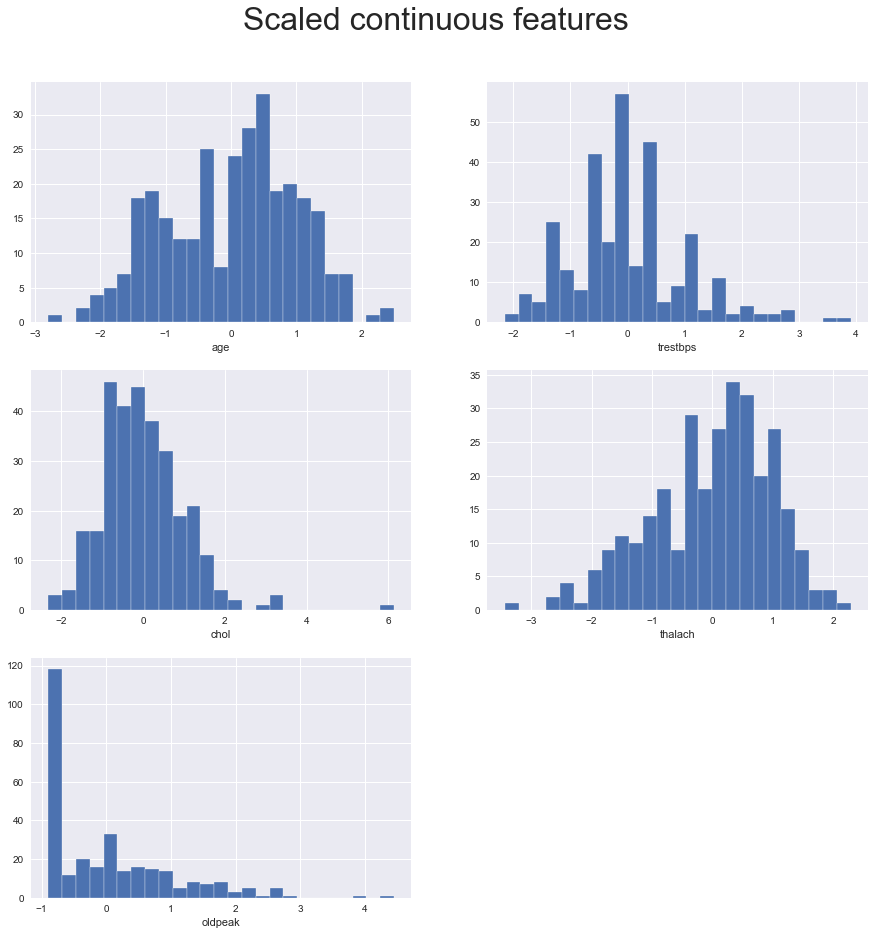

In [20]:
# Plotting the scaled continuous features
fig = plt.figure(figsize = (15, 15))
fig.suptitle('Scaled continuous features', fontsize = 32, y = 0.95)

for i, col in enumerate(cont_cols, 1):
    plt.subplot(3, 2, i)
    std_scaled[col].hist(bins = 25)
    plt.xlabel(col)

In [21]:
# Splitting data into train/test sets
from sklearn.model_selection import train_test_split

X = std_scaled.drop('target', axis = 1)
y = std_scaled.target

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7,
                                                    stratify = y, random_state = 2)

Just to be sure this was splitted correctly, let's look at the number of instances in each set:

In [22]:
print('Train set size:      ', X_train.shape[0])
print('Test set size:       ', X_test.shape[0], end = '\n\n')

total = X_train.shape[0] + X_test.shape[0]
print('Train set (%):      ', round(X_train.shape[0]/total, 2) * 100)
print('Test set (%):       ', round(X_test.shape[0]/total, 2) * 100)

Train set size:       212
Test set size:        91

Train set (%):       70.0
Test set (%):        30.0


Now that our continuous features are better scaled, we can start working with our ML algorithms to detect which ones are better suited for this problem in particular.

## 4. Applying Machine Learning algorithms

In a first instance, we'll try the following ML algorithms for our classification problem: <br> <br>
  **1.** `Logistic Regression` <br>
  **2.** `KNN` <br>
  **3.** `Decision Trees` <br>
  **4.** `Random Forests` <br>
  **5.** `XGBoost` <br>
  **6.** `SVM`


As we'll be using several ML algorithms, and in all of them we want to know the error metrics for each one of them, it will probably be easier to define a function for this purpose.

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Function for printing a report with the model's score
def model_score(model, X_train, y_train, X_test, y_test, train = True, test = True):
    
    if train:
        pred = model.predict(X_train)
        print('\033[1mTRAIN RESULTS', '\033[0m', end = '\n\n')
        print('\033[1mAccuracy score:', '\033[0m', "{:.2f}".format(accuracy_score(y_train, pred) * 100),  end = '\n\n')
        report = pd.DataFrame(classification_report(y_train, pred, output_dict = True))
        print('\033[1mClasification report:\n', '\033[0m', report, end = '\n\n')
        conf_matrix = confusion_matrix(y_train, pred)
        print('\033[1mConfusion Matrix:\n', '\033[0m')
        df_conf_matrix = pd.DataFrame(conf_matrix)
        plt.figure(figsize = (2.5,2))
        sns.heatmap(df_conf_matrix, annot = True, annot_kws = {"size": 12}, fmt = '.0f',
                 cmap = 'YlOrRd')
        plt.show()
        print('\n')
    
    if test:
        pred = model.predict(X_test)
        print('\033[1mTEST RESULTS', '\033[0m', end = '\n\n')
        print('\033[1mAccuracy score:', '\033[0m', "{:.2f}".format(accuracy_score(y_test, pred) * 100),  end = '\n\n')
        report = pd.DataFrame(classification_report(y_test, pred, output_dict = True))
        print('\033[1mClasification report:\n', '\033[0m', report, end = '\n\n')
        conf_matrix = confusion_matrix(y_test, pred)
        print('\033[1mConfusion Matrix:\n', '\033[0m')
        df_conf_matrix = pd.DataFrame(conf_matrix)
        plt.figure(figsize = (2.5,2))
        sns.heatmap(df_conf_matrix, annot = True, annot_kws = {"size": 12}, fmt = '.0f',
                 cmap = 'YlOrRd')
        plt.show()
        

This function basically takes the model we want to print its score and we can print either the training score, the testing score or both via the `train` and `test` attributes that by default are set to *True*.

### 4.1 Logistic Regression

In [24]:
# Basic Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver = 'liblinear', random_state = 2)
lr = lr.fit(X_train, y_train)

Now, let's print the score for this Logistic Regression model

TRAIN RESULTS 

Accuracy score:  87.26

Clasification report:
                0      1  accuracy  macro avg  weighted avg
precision  0.88   0.87      0.87       0.87          0.87
recall     0.84   0.90      0.87       0.87          0.87
f1-score   0.86   0.89      0.87       0.87          0.87
support   97.00 115.00      0.87     212.00        212.00

Confusion Matrix:
 


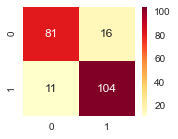



TEST RESULTS 

Accuracy score:  86.81

Clasification report:
                0     1  accuracy  macro avg  weighted avg
precision  0.82  0.91      0.87       0.87          0.87
recall     0.90  0.84      0.87       0.87          0.87
f1-score   0.86  0.87      0.87       0.87          0.87
support   41.00 50.00      0.87      91.00         91.00

Confusion Matrix:
 


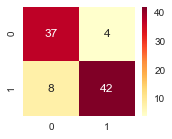

In [25]:
model_score(lr, X_train, y_train, X_test, y_test)

As we may see, the overall metric scores for the training set is a little bit higher than the test set. This could be evidencing some overfitting on our training set in case of a higher gap. 

In order to get rid of this, we can tune the regularization that is being used by default by sklearn's `LogisticRegression`, which is an `l2` or `Ridge Regression` which adds a penalization term to the logistic regression function. Also, the default `C` hyperparameter value of this penalization is 1. We can also tweak this value for reducing this overfitting. When C = 0 then it's common Linear Regression, the greater C is, the more regularized model we obtain (lower chance of overfitting).

As a rule of hand, Ridge Regression is a good default unless you suspect that only few features are actually useful, then you should consider `Lasso Regression` (that performs `feature selection`) or some midground with `Elastic Net`. In this case we saw that most of the features are useful (in the EDA part).

Taking this into account, to fine-tune our Logistic Regression model we'll ise sklearn's `GridSearchCV` for exploring different values for our hyperparameters. There's also the `RandomizedSearchCV` available, but it-s usually prefered when the search space is large.

In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
# Finding better hyperparameters for the Logistic Regression
lr_params = [ {'C': np.logspace(-1, 0.3, 30)} ]

lr = LogisticRegression(solver = 'liblinear', random_state = 2)
lr_cv = GridSearchCV(lr, lr_params, cv = 5, scoring = 'accuracy')
lr_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=2, solver='liblinear'),
             param_grid=[{'C': array([0.1       , 0.11087346, 0.12292923, 0.13629589, 0.15111596,
       0.16754749, 0.1857657 , 0.20596485, 0.22836034, 0.25319101,
       0.28072162, 0.31124576, 0.34508894, 0.38261203, 0.42421518,
       0.47034203, 0.52148447, 0.57818786, 0.64105686, 0.7107619 ,
       0.78804628, 0.87373415, 0.96873925, 1.07407469, 1.19086373,
       1.32035178, 1.46391965, 1.62309832, 1.7995852 , 1.99526231])}],
             scoring='accuracy')

Now, let's look at the best value of C from the ones we tried

In [28]:
lr_best_params = lr_cv.best_params_
print(lr_best_params)

{'C': 0.1}


Now we re-train the model with the best params and print the scores' report

In [29]:
lr = LogisticRegression(**lr_best_params)
lr.fit(X_train, y_train)

LogisticRegression(C=0.1)

TRAIN RESULTS 

Accuracy score:  84.91

Clasification report:
                0      1  accuracy  macro avg  weighted avg
precision  0.86   0.84      0.85       0.85          0.85
recall     0.80   0.89      0.85       0.85          0.85
f1-score   0.83   0.86      0.85       0.85          0.85
support   97.00 115.00      0.85     212.00        212.00

Confusion Matrix:
 


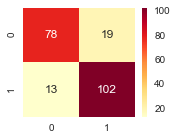



TEST RESULTS 

Accuracy score:  85.71

Clasification report:
                0     1  accuracy  macro avg  weighted avg
precision  0.80  0.91      0.86       0.86          0.86
recall     0.90  0.82      0.86       0.86          0.86
f1-score   0.85  0.86      0.86       0.86          0.86
support   41.00 50.00      0.86      91.00         91.00

Confusion Matrix:
 


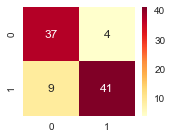

In [30]:
model_score(lr, X_train, y_train, X_test, y_test)

We can append the results to a DataFrame for comparing the different models

In [33]:
test_score = accuracy_score(y_test, lr.predict(X_test)) * 100
train_score = accuracy_score(y_train, lr.predict(X_train)) * 100

results_df = pd.DataFrame(data = [["Logistic Regression", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression,84.91,85.71


## 4.2 KNN

TRAIN RESULTS 

Accuracy score:  90.57

Clasification report:
                0      1  accuracy  macro avg  weighted avg
precision  0.94   0.88      0.91       0.91          0.91
recall     0.85   0.96      0.91       0.90          0.91
f1-score   0.89   0.92      0.91       0.90          0.91
support   97.00 115.00      0.91     212.00        212.00

Confusion Matrix:
 


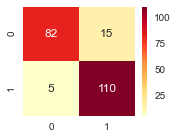



TEST RESULTS 

Accuracy score:  82.42

Clasification report:
                0     1  accuracy  macro avg  weighted avg
precision  0.80  0.84      0.82       0.82          0.82
recall     0.80  0.84      0.82       0.82          0.82
f1-score   0.80  0.84      0.82       0.82          0.82
support   41.00 50.00      0.82      91.00         91.00

Confusion Matrix:
 


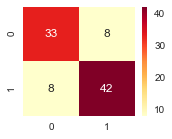

In [57]:
# KNN Classifier with default values
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

model_score(knn, X_train, y_train, X_test, y_test)

Let's look the different values of the training and test accuracies for different values of `n_neighbors`. Also, we'll try different algorithms for KNN as `ball_tree`, `kd_tree` and `brute`. The default is `auto` attemps to decide the most appropiate algorithm based on the values passed to the `fit` method.

In [87]:
# KNN accuracies with 1-30 neighbors
neighbors = range(1, 31)
train_score = []
test_score = []

for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors = n, algorithm = 'kd_tree') 
    knn.fit(X_train, y_train)
    train_score.append(accuracy_score(y_train, knn.predict(X_train)))
    test_score.append(accuracy_score(y_test, knn.predict(X_test)))

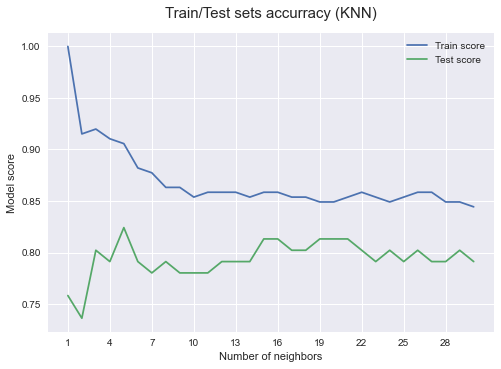

In [88]:
# Plotting training and testing accuracies
plt.plot(neighbors, train_score, label = "Train score")
plt.plot(neighbors, test_score, label = "Test score")

plt.title('Train/Test sets accurracy (KNN)', fontsize = 15, y = 1.03)
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")

plt.xticks(np.arange(1, 30, 3))
plt.legend()